# Неделя 3. Четверг

### feature selection

Отбор признаков — это удаление ненужных и оценка важности признаков при помощи алгоритмов машинного обучения.

Зачем отбирать признаки?

1. Иногда плохие, зависимые признаки ведут к мультиколлинеарности.
2. Признаков может быть много. Лучше отбросить ненужные признаки для сокращения времени обучения.
3. Нам может быть необходимо выделить лучшие признаки и понять, насколько нам их будет хватать в будущем. То есть упростить модель, чтобы повысить интерпретируемость.

In [27]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [28]:
plt.rcParams['figure.figsize'] = [15,7]

In [40]:
df = pd.read_csv('aux/boston.csv').drop('Unnamed: 0', axis=1)

X, y = df.loc[:, df.columns != 'medv'], df['medv']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in \$1000's

## 1. Методы фильтрации(filter methods)

_Методы фильтрации применяются до обучения модели и, как правило, имеют низкую стоимость вычислений. К ним можно отнести визуальный анализ (например, удаление признака, у которого только одно значение, или большинство значений пропущено), оценку признаков с помощью какого-нибудь статистического критерия (дисперсии, корреляции, X2 и др.) и экспертную оценку (удаление признаков, которые не подходят по смыслу, или признаков с некорректными значениями)._

### 1.1 Матрица корреляции

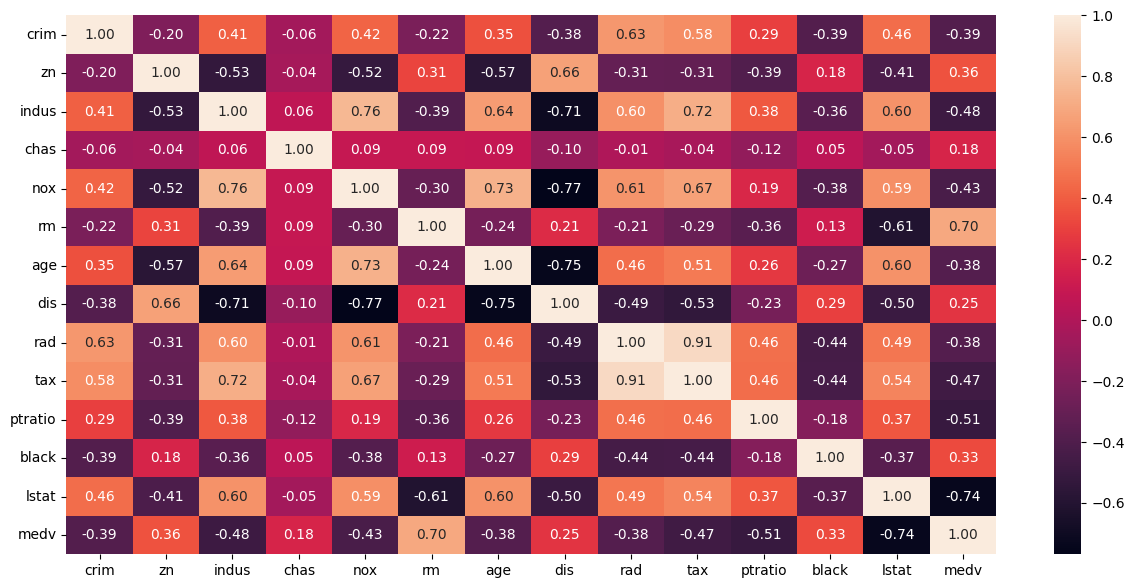

In [41]:
sns.heatmap(df.corr(), annot=True, fmt='.2f');

In [42]:
df.corr()['medv'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

lstat     -0.737663
rm         0.695360
ptratio   -0.507787
indus     -0.483725
tax       -0.468536
nox       -0.427321
crim      -0.388305
rad       -0.381626
age       -0.376955
zn         0.360445
black      0.333461
dis        0.249929
chas       0.175260
Name: medv, dtype: float64

### 1.2 F-test

_В sklearn это реализовано в модулях `sklearn.feature_selection.f_regression` и `sklearn.feature_selection.f_classif`. На выходе получаем p-value, который показывает, есть ли взаимосвязь между конкретным предиктором и таргетом_

In [43]:
pd.Series(dict(zip(X.columns, f_regression(X, y)[1]))).sort_values()

lstat      5.081103e-88
rm         2.487229e-74
ptratio    1.609509e-34
indus      4.900260e-31
tax        5.637734e-29
nox        7.065042e-24
crim       1.173987e-19
rad        5.465933e-19
age        1.569982e-18
zn         5.713584e-17
black      1.318113e-14
dis        1.206612e-08
chas       7.390623e-05
dtype: float64

_Как мы можем видеть, везде p-value оч низко, все признаки визуально важны_

### 1.3 Lasso, как способ отбора признаков

In [44]:
lasso = Lasso(alpha= 0.4)
lasso.fit(X, y)

Lasso(alpha=0.4)

In [45]:
pd.Series(dict(zip(X.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

rm         2.803845
dis       -0.995073
ptratio   -0.765559
lstat     -0.634946
rad        0.278803
crim      -0.087423
zn         0.049486
tax       -0.015346
indus     -0.011115
black      0.009702
age        0.000231
chas       0.000000
nox       -0.000000
dtype: float64

### 1.4 Feature_importances деревянных моделей

In [46]:
rf = RandomForestRegressor()

rf.fit(X, y)

RandomForestRegressor()

In [47]:
pd.Series(dict(zip(X.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)

rm         0.425665
lstat      0.376623
dis        0.068594
crim       0.036607
nox        0.023907
ptratio    0.017273
tax        0.015442
age        0.012030
black      0.011000
indus      0.006160
rad        0.004031
chas       0.001336
zn         0.001333
dtype: float64

* Интересная идея в _feature_importances_

In [48]:
X['random'] = np.random.uniform(0,100, size=X.shape[0])

In [49]:
rf = RandomForestRegressor()

rf.fit(X, y)

pd.Series(dict(zip(X.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)

rm         0.410465
lstat      0.387049
dis        0.067353
crim       0.038368
nox        0.025761
ptratio    0.016880
tax        0.013935
age        0.011329
black      0.010042
random     0.008486
indus      0.005320
rad        0.002717
zn         0.001286
chas       0.001009
dtype: float64

* Все что оказалось ниже рандомного признака не важно, можно удалять, правда лучше проделать такую операцию с рандомным признаком ни 1 раз, а больше и посмотреть на среднюю важность. Один рандом может оказаться случайно псевдозначимым

### 1.5 Permutation importance

In [50]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [51]:
r = permutation_importance(rf, X_valid, y_valid, n_repeats=30, random_state=0)

In [52]:
pd.Series(dict(zip(X.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)

lstat      0.667126
rm         0.498896
indus      0.025795
tax        0.024180
dis        0.023309
nox        0.022637
ptratio    0.016149
crim       0.013347
age        0.006381
rad        0.003496
black      0.002830
zn        -0.001653
chas      -0.000010
dtype: float64

_Так же добавим один рандомный элемент_

In [53]:
X['random'] = np.random.uniform(0,100, size=X.shape[0])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [54]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

r = permutation_importance(rf, X_valid, y_valid, n_repeats=30, random_state=0)

pd.Series(dict(zip(X.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)

lstat      0.711620
rm         0.485309
dis        0.106592
crim       0.015755
nox        0.011469
tax        0.010304
age        0.005145
ptratio    0.003150
random    -0.001638
black      0.000666
indus     -0.000629
rad       -0.000518
zn         0.000242
chas      -0.000105
dtype: float64

### 1.6 Shap values

больше графиков и примеров тут - https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

In [55]:
from catboost import CatBoostRegressor
shap.initjs()

In [56]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, verbose=False, plot=False)

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

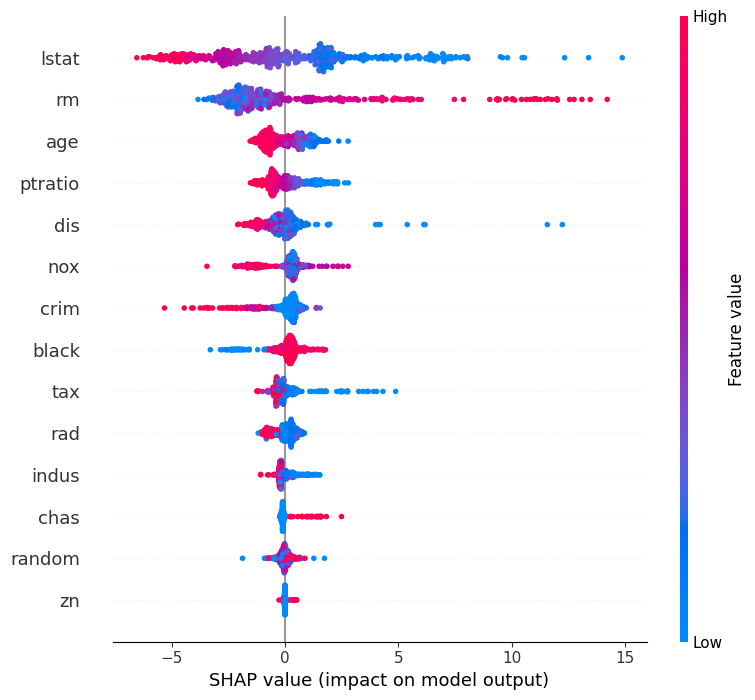

In [58]:
shap.summary_plot(shap_values, X)